## Implémentation loi multinormale

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm

#### dimension 1

In [2]:
def simulNormal(mu, sigma, m, N, eps, T):
    
    def deltaV(x):  # gradient de V 
        return 1/sigma*(x-mu)  
    
    chain = [] 
    q = mu # point de départ : espérance
    chain.append(q)
    acc = 0 # calculer le taux d'acceptation de Metropolis Hastings
    
    for n in range(1,N): # nombre de point de la chaine
        
        p = np.random.normal(0,m,1)[0] # p (le moment) suit une loi N(0,m)
        q = chain[n-1]
        pstar = p
        qstar = q
        
        for t in range(T): # leapfrog integrator
            ptemp = pstar - eps/2*deltaV(qstar)
            qstar = qstar + eps*ptemp
            pstar = ptemp - eps/2*deltaV(qstar)
        
        H = - norm(mu, sigma).logpdf(q) - norm(0,m).logpdf(p) # calcul de H(p,q)
            
        Hstar = - norm(mu, sigma).logpdf(qstar) - norm(0, m).logpdf(pstar) # calcul de H(p*,q*)
            
        r = min(1,np.exp(H-Hstar)) 
        
        if (np.random.uniform(0,1,1)<r):
            chain.append(qstar)
            acc+=1
        else:
            chain.append(q)
        
    return {"chain" : np.array(chain), 'acc' : acc/N}

In [35]:
mu = 1.4
sigma = 2
m = 1

out = simulNormal(mu, sigma, m, 15000, 0.1, 15)
chain = out['chain']
acc = out['acc']

0.8028

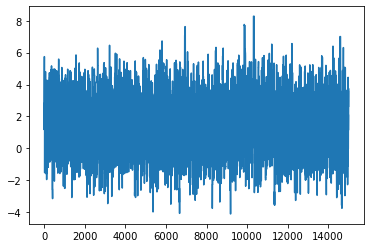

In [36]:
plt.plot(chain);
acc

C:\Users\marco\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


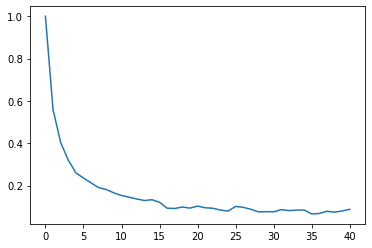

In [16]:
import statsmodels.tsa.stattools
plt.plot(statsmodels.tsa.stattools.acf(chain,nlags=40))

On prélève une sous chaine pour éviter la dépendance temporelle

C:\Users\marco\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


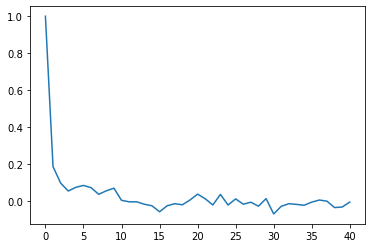

In [19]:
chaintronc = chain[[i%10==0 for i in range(len(chain))]]
plt.plot(statsmodels.tsa.stattools.acf(chaintronc,nlags=40))

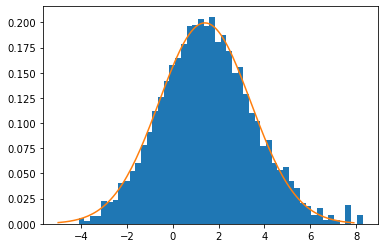

In [37]:
plt.hist(chain, bins=50, density=True)
plt.plot(np.arange(-5,8,0.1), norm.pdf(np.arange(-5,8,0.1), loc=mu, scale=sigma));

#### dimension 2

Différence dans le code : dimension supérieur à un et  nouvelle sortie 'road' qui nous donne tous les points parcourus par la boucle leapfrog 

In [61]:
def simulMultivariatedim2(mu, sigma, M, N, eps, T):
    
    def deltaV(x):
        return np.dot(np.linalg.inv(sigma),(x-mu))
    
    chain = []
    chainp = []
    completeroad = []
    q = mu
    chain.append(q.tolist())
    acc = 0
    
    for n in range(1,N):
        
        dim = len(mu)
        road = []
        p = np.random.multivariate_normal(np.zeros(dim),M,1)[0]
        chainp.append(p.tolist())
        q = chain[n-1]
        pstar = p
        qstar = q
        road.append(q)
        
        for t in range(T):
            ptemp = pstar - eps/2*deltaV(qstar)
            qstar = qstar + eps*ptemp
            pstar = ptemp - eps/2*deltaV(qstar)
            road.append(qstar.tolist())
        H = - multivariate_normal(mu, sigma).logpdf(q) -multivariate_normal(np.zeros(dim), M).logpdf(p)
            
        Hstar = - multivariate_normal(mu, sigma).logpdf(qstar) - multivariate_normal(np.zeros(dim), M).logpdf(pstar)
            
        r = min(1,np.exp(H-Hstar))
        
        if (np.random.uniform(0,1,1)<r):
            chain.append(qstar.tolist())
            completeroad += road
            acc+=1
        else:
            chain.append(q)
        
    return {"chain" : np.array(chain), 'acc' : acc/N, "road": np.array(completeroad), "chainp" : np.array(chainp)}
            

In [122]:
mu = np.array([0,0])
sigma = np.array([[1,0.5],[0.5,1]])
M = np.array([[1,0],[0,1]])

out = simulMultivariatedim2(mu, sigma, M, 3, 0.1, 40)
chain = out['chain']
acc = out['acc']
road = out['road']
chainp = out['chainp']

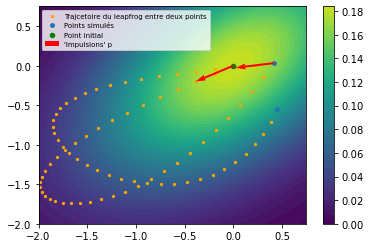

In [124]:
fig = plt.figure()


x,y = np.meshgrid(np.linspace(-2,0.75,100),np.linspace(-2,0.75,100))
z = np.zeros((len(x),len(x[0])))
for i in range(len(x)):
    for j in range(len(x[0])):
        z[i][j] = multivariate_normal(mu,sigma).pdf([x[i][j],y[i][j]])


ax = fig.add_subplot(111)
cf = ax.contourf(x,y,z,51,vmin=0,vmax=0.2,cmap='viridis')
cbar = fig.colorbar(cf)
cbar.update_ticks()

ax.scatter(road[:,0],road[:,1],c='orange',s=5, label='Trajcetoire du leapfrog entre deux points')
ax.scatter(chain[:,0],chain[:,1],s=15, label ='Points simulés')
ax.scatter(chain[0,0], chain[0,1], c='green', s=20,label='Point initial')
ax.quiver(chain[:-1,0], chain[:-1,1], chainp[:,0], chainp[:,1], angles='xy', scale_units='xy', scale=5, color="red", label='\'Impulsions\' p');
ax.legend(prop={'size':7}, loc='upper left');

In [127]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
def gamma(x, y, mu_x, mu_y, sigma):
    return (np.exp(-(np.power(x - mu_x, 2) + np.power(y - mu_y, 2))
                    / (2*sigma**2))
             / (2 * np.pi * sigma**2))
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)

v_x, v_y= np.meshgrid(x, y)
v_z = gamma(v_x, v_y, 0, 0, 1)

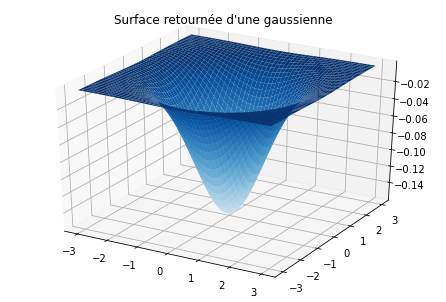

In [143]:
fig,ax = plt.subplots(1,2)
ax[0] = Axes3D(fig)
ax[0].plot_surface(v_x, v_y, v_z, cmap='Blues', vmin=0, vmax=0.2)
ax[0].set_title('Surface d\'une gaussienne')
ax[1] = Axes3D(fig)
ax[1].plot_surface(v_x, v_y, -v_z, cmap='Blues', vmin=-0.20, vmax=-0)
ax[1].set_title('Surface retournée d\'une gaussienne')
plt.show();

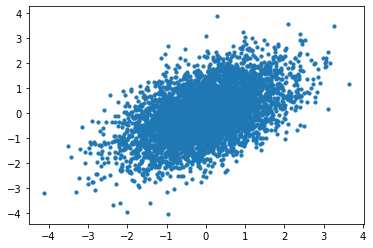

In [108]:
out = simulMultivariatedim2(mu, sigma, M, 5000, 0.1, 15)
chain = out['chain']
acc = out['acc']
road = out['road']
plt.scatter(chain[:,0],chain[:,1],s=10);

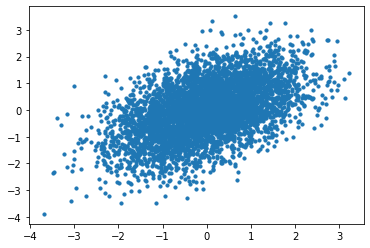

In [12]:
X = np.random.multivariate_normal(mu, sigma, 5000)
plt.scatter(X[:,0], X[:,1],s=10);

#### dimension 3

In [13]:
def simulMultivariate(mu, sigma, M, N, eps, T):
    
    def deltaV(x):
        return np.dot(np.linalg.inv(sigma),(x-mu))
    
    chain = []
    q = mu
    chain.append(q.tolist())
    acc = 0
    
    for n in range(1,N):
        
        dim = len(mu)
        p = np.random.multivariate_normal(np.zeros(dim),M,1)[0]
        q = chain[n-1]
        pstar = p
        qstar = q
        
        for t in range(T):
            ptemp = pstar - eps/2*deltaV(qstar)
            qstar = qstar + eps*ptemp
            pstar = ptemp - eps/2*deltaV(qstar)
        
        H = - multivariate_normal(mu, sigma).logpdf(q) - multivariate_normal(np.zeros(dim), M).logpdf(p)
            
        Hstar = - multivariate_normal(mu, sigma).logpdf(qstar) - multivariate_normal(np.zeros(dim), M).logpdf(pstar)
            
        r = min(1,np.exp(H-Hstar))
        
        if (np.random.uniform(0,1,1)<r):
            chain.append(qstar.tolist())
            acc+=1
        else:
            chain.append(q)
        
    return {"chain" : np.array(chain), 'acc' : acc/N}
            

In [14]:
mu = np.array([0,0,0])
sigma = np.array([[1,0.5,-0.3],[0.5,1,0.1],[-0.3,0.1,1]])
M = np.array([[1,0,0],[0,1,0],[0,0,1]])

out = simulMultivariate(mu, sigma, M, 1000, 0.2, 50)
chain = out['chain']
acc = out['acc']

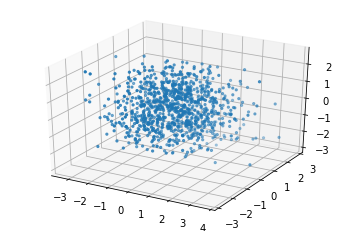

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(chain[:,0], chain[:,1], chain[:,2],s=5);

In [16]:
print(chain[200:].mean(axis=0))
np.cov([chain[:,0],chain[:,1],chain[:,2]])

[-0.05175258 -0.02812792  0.01375216]


array([[ 1.05043748,  0.49956598, -0.35000715],
       [ 0.49956598,  0.89894631,  0.08340814],
       [-0.35000715,  0.08340814,  1.0264527 ]])

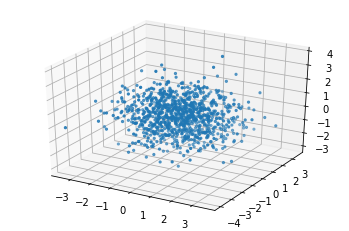

In [17]:
X = np.random.multivariate_normal(mu, sigma, 1000)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2],s=5);

In [18]:
print(X.mean(axis=0))
np.cov([X[:,0],X[:,1],X[:,2]])

[ 0.00093552 -0.00505091 -0.009551  ]


array([[ 1.08387189,  0.56071688, -0.26636978],
       [ 0.56071688,  1.05859385,  0.09530071],
       [-0.26636978,  0.09530071,  1.05115696]])

## Grande dimension

In [144]:
def simulMultivariate(mu, sigma, M, N, eps, T):
    
    def deltaV(x):
        return np.dot(np.linalg.inv(sigma),(x-mu))
    
    chain = []
    q = mu
    chain.append(q.tolist())
    acc = 0
    
    for n in range(1,N):
        
        dim = len(mu)
        p = np.random.multivariate_normal(np.zeros(dim),M,1)[0]
        q = chain[n-1]
        pstar = p
        qstar = q
        
        for t in range(T):
            ptemp = pstar - eps/2*deltaV(qstar)
            qstar = qstar + eps*ptemp
            pstar = ptemp - eps/2*deltaV(qstar)
        
        H = - multivariate_normal(mu, sigma).logpdf(q) - multivariate_normal(np.zeros(dim), M).logpdf(p)
            
        Hstar = - multivariate_normal(mu, sigma).logpdf(qstar) - multivariate_normal(np.zeros(dim), M).logpdf(pstar)
            
        r = min(1,np.exp(H-Hstar))
        
        if (np.random.uniform(0,1,1)<r):
            chain.append(qstar.tolist())
            acc+=1
        else:
            chain.append(q)
        
    return {"chain" : np.array(chain), 'acc' : acc/N}

In [186]:
mu = np.zeros(50)
sigma = np.eye(50)
M = np.eye(50)
Nchain = 10000
epsilon = 0.2
T=100

dim = 50

out = simulMultivariate(mu, sigma, M, Nchain, epsilon, T)
chain = out['chain']
acc = out['acc']

0.11099153511242245

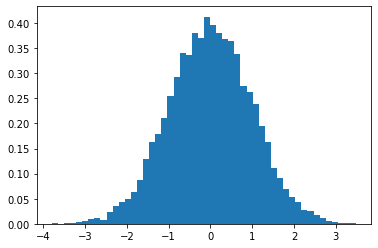

In [190]:
plt.hist(chain[:,4],bins=50,density=True);
np.sqrt(sum(np.mean(chain,axis=0)**2))


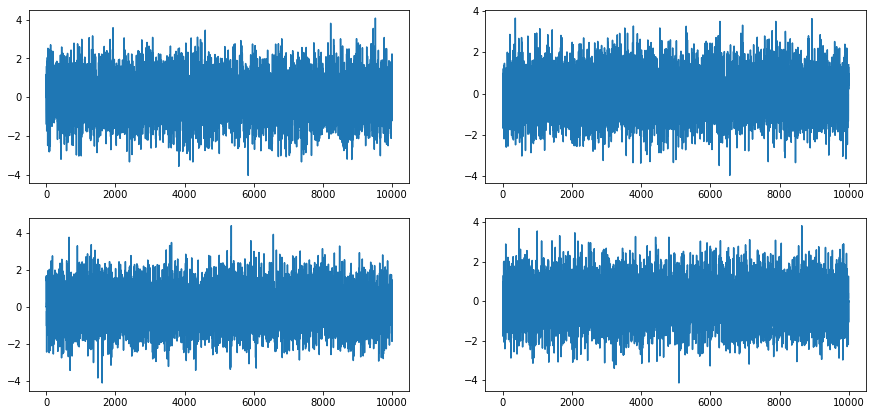

In [198]:
fig, ax = plt.subplots(2,2, figsize=(15,7))
for i in range(4):
    ax[i%2][i//2].plot(chain[:,i])

In [ ]:
norm()

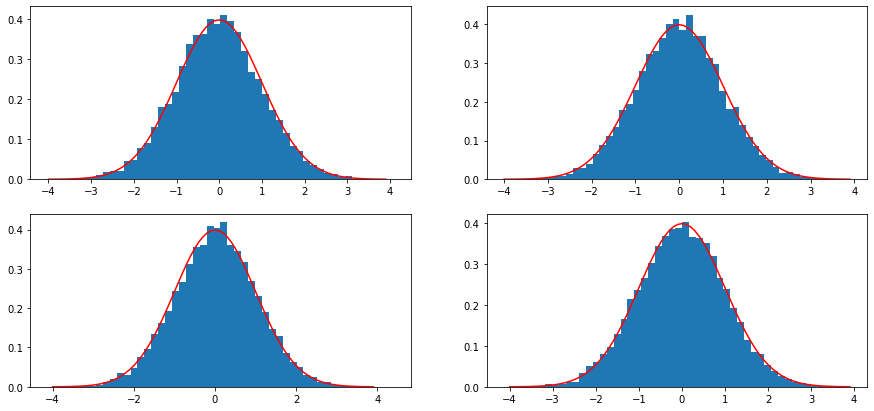

In [204]:
fig, ax = plt.subplots(2,2, figsize=(15,7))
for i in range(4):
    ax[i%2][i//2].hist(chain[:,i],bins=50,density=True)
    ax[i%2][i//2].plot(np.arange(-4,4,0.1), norm.pdf(np.arange(-4,4,0.1)), c='red')

In [193]:
np.sqrt(sum(np.mean(np.random.multivariate_normal(mu,sigma,Nchain),axis=0)**2))

0.07074773849791649